# Kelompok 3
- Astrid Risa Widiana (2241720250)
- Muhammad Nurul Mustofa (2241720022)
- Tirta Nurrochman Bintang Prawira (2241720045)
- Yogianna Nur Febrianti (2241720261)

# **Job Sheet 10 : Recurrent Neural Network (RNN)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Praktikum 1 RNN untuk Analisis Sentimen

### **Setup**
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Kode di atas mengimpor tiga pustaka: `numpy` untuk operasi numerik, `tensorflow_datasets` untuk mengakses kumpulan data pra-proses, dan `tensorflow` untuk membangun serta melatih model machine learning. Baris terakhir, `tfds.disable_progress_bar()`, menonaktifkan tampilan bar progres saat memuat data dari `tensorflow_datasets`, sehingga output tampak lebih ringkas saat dijalankan.

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
     plt.plot(history.history[metric])
     plt.plot(history.history['val_'+metric], '')
     plt.xlabel("Epochs")
     plt.ylabel(metric)
     plt.legend([metric, 'val_'+metric])

Kode ini mendefinisikan fungsi `plot_graphs`, yang digunakan untuk membuat grafik metrik kinerja model selama pelatihan, seperti akurasi atau loss. Fungsi ini menerima `history` (objek hasil pelatihan model) dan `metric` (nama metrik yang akan ditampilkan). Fungsi akan menampilkan grafik metrik pada data pelatihan dan validasi berdasarkan jumlah epoch, dengan label dan legenda untuk membedakan kedua garis tersebut.

# Setup input pipeline

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Kode ini memuat dataset ulasan IMDb menggunakan `tfds.load` dari pustaka `tensorflow_datasets`, dengan parameter `with_info=True` untuk menyertakan informasi dataset dan `as_supervised=True` agar data diformat dalam pasangan (input, label). Variabel `train_dataset` dan `test_dataset` memisahkan data pelatihan dan pengujian. Baris `train_dataset.element_spec` menampilkan spesifikasi elemen data, menunjukkan bahwa inputnya berupa teks (`tf.string`), dan labelnya berupa nilai numerik (`tf.int64`).

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Kode ini mengambil satu contoh dari `train_dataset` dan mencetak teks serta labelnya. Dalam loop, `example.numpy()` mengonversi teks ulasan menjadi string yang dapat dibaca, sedangkan `label.numpy()` menampilkan label numeriknya, di mana `0` menunjukkan ulasan negatif dan `1` menunjukkan ulasan positif. Contoh yang dicetak menggambarkan teks ulasan film yang negatif.

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Anthony Mann\'s westerns with Jimmy Stewart are slowly gaining for that director a position with John Ford and Howard Hawks as the best film director in that genre. He certainly knows how to give dimension to nice guy Stewart - in Mann\'s films there is an edge to Jimmy that is slowly demonstrated to the audience. In WINCHESTER \'73 it was the relationship of Stewart to his brother and how it twists him into a figure of vengeance. Here it is a "I trust only myself" attitude, which leads to one complication after another. Even before the film properly begins he (as Jeff Webster) kills two of his hired cowboys who were helping on a cattle drive to Seattle because of some dispute (we never are clear about it - either they wanted to leave the cattle drive, or they tried to steal the cattle). <br /><br />He meets his match in Skagway, the port he has to get to in order to take his herd to Dawson. Skagway\'s boss is a so-called law man named Gannon (John McIntyre) who reminds one 

Kode ini menyiapkan `train_dataset` dan `test_dataset` dengan proses *shuffle* untuk melatih model secara acak, mengelompokkan data dalam ukuran *batch* 64, dan menggunakan `prefetch` untuk mempercepat pemrosesan data. Variabel `BUFFER_SIZE` menentukan ukuran penyangga untuk *shuffle*, dan `BATCH_SIZE` menentukan ukuran *batch*. Loop terakhir mengambil tiga contoh teks dan label pertama dari `train_dataset`, mencetak tiga ulasan sebagai teks dan labelnya (dalam bentuk 0 atau 1) untuk memeriksa format data.

### **Buat Teks Encoder**

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[  1,   1,   1, ...,   0,   0,   0],
       [ 86, 127, 372, ..., 290, 336,   1],
       [ 11,   7, 176, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

-Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

-Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Anthony Mann\'s westerns with Jimmy Stewart are slowly gaining for that director a position with John Ford and Howard Hawks as the best film director in that genre. He certainly knows how to give dimension to nice guy Stewart - in Mann\'s films there is an edge to Jimmy that is slowly demonstrated to the audience. In WINCHESTER \'73 it was the relationship of Stewart to his brother and how it twists him into a figure of vengeance. Here it is a "I trust only myself" attitude, which leads to one complication after another. Even before the film properly begins he (as Jeff Webster) kills two of his hired cowboys who were helping on a cattle drive to Seattle because of some dispute (we never are clear about it - either they wanted to leave the cattle drive, or they tried to steal the cattle). <br /><br />He meets his match in Skagway, the port he has to get to in order to take his herd to Dawson. Skagway\'s boss is a so-called law man named Gannon (John McIntyre) who reminds on

Kode tersebut mendefinisikan model Keras sederhana untuk memproses urutan, yang menggabungkan encoder, lapisan embedding, LSTM bidirectional, dan dua lapisan dense.

Output menunjukkan tiga contoh dengan teks asli dan teks "round-trip", yang menampilkan versi yang didekode setelah melewati model. Teks round-trip mengandung banyak token `[UNK]`, yang menunjukkan bahwa beberapa kata tidak dikenali atau tidak dapat dikodekan. Ini menunjukkan bahwa kosakata yang digunakan dalam model mungkin terbatas atau tidak sepenuhnya menangkap teks aslinya.

### **Buat Model**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Kode ini mendefinisikan model *neural network* menggunakan Keras. Model dimulai dengan `encoder` untuk memproses input teks, diikuti oleh lapisan `Embedding` yang mengonversi kata-kata menjadi representasi vektor berdimensi 64. Kemudian, lapisan `Bidirectional LSTM` mengolah data urutan dengan mempelajari konteks dari kedua arah (maju dan mundur). Setelah itu, ada lapisan `Dense` dengan 64 neuron dan fungsi aktivasi ReLU, diakhiri dengan lapisan `Dense` terakhir yang memiliki satu neuron untuk menghasilkan output, yang bisa digunakan untuk prediksi biner (seperti klasifikasi ulasan positif atau negatif).

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Perintah `print([layer.supports_masking for layer in model.layers])` digunakan untuk memeriksa apakah setiap lapisan dalam model mendukung fitur masking. Output yang dihasilkan, yaitu `[False, True, True, True, True]`, menunjukkan bahwa lapisan pertama tidak mendukung masking, sementara keempat lapisan berikutnya mendukungnya. Ini berarti bahwa lapisan-lapisan tersebut dapat menangani input dengan panjang yang bervariasi dan dapat mengabaikan elemen yang tidak relevan (biasanya yang bernilai nol) saat memproses data. Fitur ini sangat berguna dalam model yang beroperasi pada data sekuensial seperti teks.

In [ ]:
import numpy as np
import tensorflow as tf

# Fungsi untuk memproses teks menjadi dataset
def create_dataset(text):
    return tf.data.Dataset.from_tensor_slices([text]).batch(1)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
dataset = create_dataset(sample_text)

# Prediksi menggunakan model
predictions = model.predict(dataset)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[0.0057163]


Kode program ini mengimpor pustaka NumPy dan TensorFlow, lalu mendefinisikan fungsi `create_dataset` untuk mengubah teks menjadi dataset TensorFlow. Dalam contoh ini, `sample_text` adalah ulasan film yang diproses menggunakan fungsi tersebut menjadi sebuah dataset dengan batch size 1. Model kemudian melakukan prediksi pada dataset ini, dan hasil prediksinya dicetak. Output yang dihasilkan adalah nilai negatif, yang menunjukkan bahwa model mungkin memberikan penilaian yang kurang positif terhadap teks tersebut, tetapi ini tergantung pada konteks model dan skala penilaiannya.

In [ ]:
import numpy as np
import tensorflow as tf

# Fungsi untuk memproses teks menjadi dataset
def create_dataset(texts):
    return tf.data.Dataset.from_tensor_slices(texts).batch(1)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
padding = "the " * 2000  # Padding text
texts = [sample_text, padding]  # List of texts including padding

# Membuat dataset dari teks
dataset = create_dataset(texts)

# Prediksi menggunakan model
predictions = model.predict(dataset)
for pred in predictions:
    print(pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[0.0057163]
[0.0449807]


Kode program ini memproses dua teks, yaitu `sample_text` dan `padding`, untuk membuat dataset TensorFlow. Fungsi `create_dataset` menerima daftar teks dan mengubahnya menjadi dataset dengan batch size 1. Setelah itu, model melakukan prediksi pada dataset yang telah dibuat. Hasil prediksi untuk masing-masing teks dicetak satu per satu. Output menunjukkan dua nilai negatif, yang mungkin menunjukkan penilaian negatif atau rendah dari model terhadap kedua teks tersebut.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Kode ini digunakan untuk mengonfigurasi model pembelajaran mesin dengan TensorFlow. Fungsi `model.compile()` menyiapkan model dengan tiga komponen utama: fungsi loss yang digunakan adalah binary crossentropy, yang cocok untuk klasifikasi biner dan menangani output yang berupa logit. Optimizer yang dipilih adalah Adam dengan laju pembelajaran \(1 \times 10^{-4}\), yang membantu memperbarui bobot model saat pelatihan. Selain itu, metrik yang digunakan untuk mengukur kinerja model adalah akurasi. Setelah ini, model siap dilatih dengan dataset.

### **Train Model**


In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.5117 - loss: 0.6843 - val_accuracy: 0.7745 - val_loss: 0.5740
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.7761 - loss: 0.4650 - val_accuracy: 0.8458 - val_loss: 0.3535
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.8408 - loss: 0.3564 - val_accuracy: 0.8682 - val_loss: 0.3176
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.8566 - loss: 0.3304 - val_accuracy: 0.8448 - val_loss: 0.3405
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.8619 - loss: 0.3167 - val_accuracy: 0.8599 - val_loss: 0.3205
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8597 - loss: 0.3224 - val_accuracy: 0.8505 - val_loss: 0.3291
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8683 - loss: 0.3079 - val_accuracy: 0.8583 - val_loss: 0.3099
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.8711 - loss: 0.2988 - 

Kode ini digunakan untuk melatih model pembelajaran mesin dengan dataset yang telah disiapkan. Fungsi `model.fit()` menjalankan proses pelatihan selama 10 epoch, menggunakan `train_dataset` sebagai data latih dan `test_dataset` untuk validasi. Selama setiap epoch, model menghitung akurasi dan loss baik untuk data latih maupun validasi. Output menunjukkan kemajuan pelatihan, termasuk akurasi dan loss di setiap epoch, dengan akurasi validasi yang umumnya lebih tinggi daripada akurasi pada data latih, menunjukkan bahwa model belajar dengan baik dari data. Namun, ada juga fluktuasi dalam loss dan akurasi, yang bisa mengindikasikan overfitting atau tantangan dalam generalisasi pada data baru.

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8435 - loss: 0.3245
Test Loss: 0.3248208463191986
Test Accuracy: 0.8420400023460388


Kode ini digunakan untuk mengevaluasi performa model pada dataset pengujian setelah proses pelatihan. Fungsi `model.evaluate()` menghitung nilai loss dan akurasi model menggunakan `test_dataset`. Output menunjukkan bahwa model memiliki test accuracy sekitar 84.2% dan test loss sekitar 0.325. Ini berarti model dapat mengklasifikasikan data pengujian dengan baik, meskipun masih ada ruang untuk perbaikan dalam hal akurasi. Angka loss yang lebih rendah umumnya menunjukkan bahwa model lebih baik dalam memprediksi output yang benar.

(0.0, 0.662814861536026)

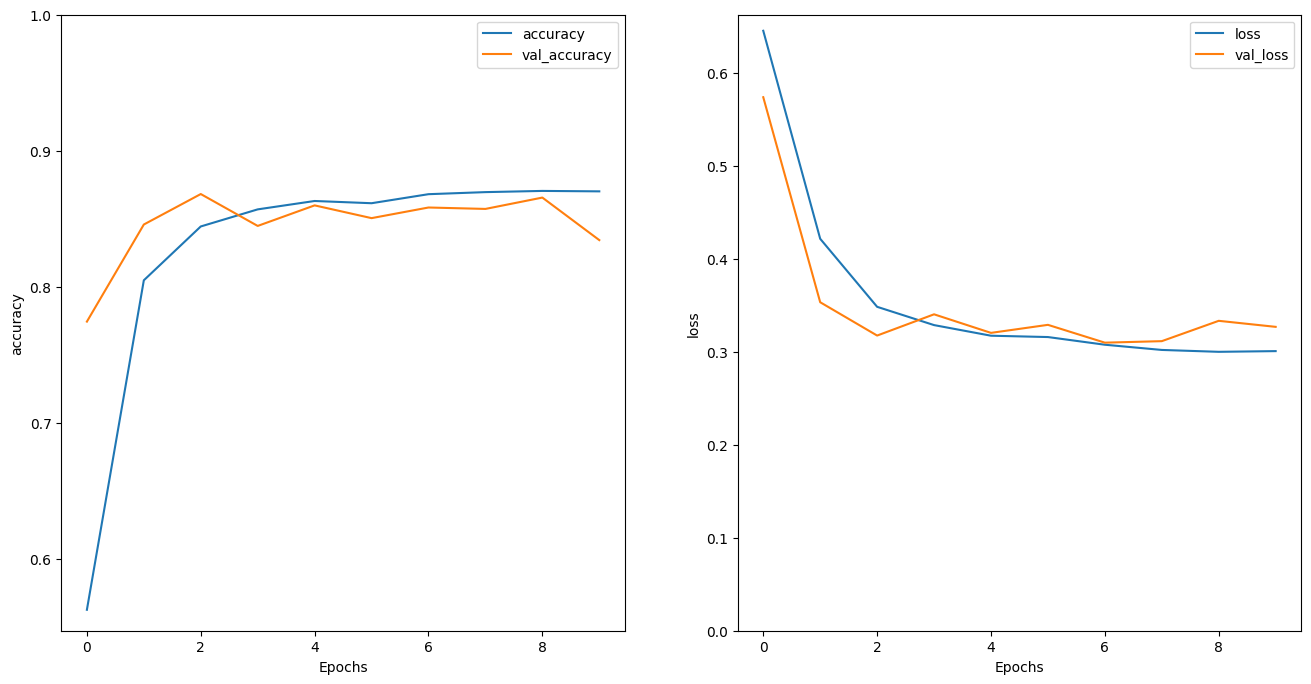

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Kode program ini digunakan untuk membuat visualisasi grafik dari hasil pelatihan model. Pertama, ukuran figure diatur menjadi 16x8 inci. Kemudian, dua subplot dibuat: yang pertama untuk menampilkan grafik akurasi model dan yang kedua untuk menampilkan grafik loss model. Fungsi `plot_graphs` dipanggil untuk menggambar grafik berdasarkan data pelatihan yang tersimpan dalam `history`, dengan batas y-axis yang disesuaikan untuk setiap grafik. Grafik-grafik ini membantu untuk memahami performa model selama pelatihan.

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:
import numpy as np
import tensorflow as tf

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Mengonversi teks menjadi tensor
sample_tensor = tf.convert_to_tensor([sample_text])

# Prediksi menggunakan model
predictions = model.predict(sample_tensor)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.84650177]


Kode yang Anda berikan mengonversi sebuah ulasan film menjadi tensor menggunakan TensorFlow dan kemudian menggunakan model untuk melakukan prediksi. Pertama, ulasan film didefinisikan dalam variabel `sample_text`. Setelah itu, teks ini diubah menjadi tensor dengan fungsi `tf.convert_to_tensor()`. Kemudian, model melakukan prediksi pada tensor tersebut dan hasilnya dicetak. Output yang dihasilkan menunjukkan nilai prediksi, yang biasanya merepresentasikan seberapa besar kemungkinan ulasan tersebut positif atau negatif.

# **Stack two or more LSTM layers**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

Kode tersebut mendefinisikan sebuah model jaringan saraf menggunakan TensorFlow Keras. Model ini merupakan model sekuensial yang terdiri dari beberapa lapisan. Pertama, ada encoder yang memproses data input, diikuti oleh lapisan embedding yang mengonversi kata menjadi vektor berdimensi 64 dengan dukungan untuk masking. Kemudian, terdapat dua lapisan LSTM yang saling terhubung dua arah (Bidirectional), yang membantu model menangkap konteks dari kedua arah dalam data sekuensial. Setelah itu, lapisan Dense dengan aktivasi ReLU ditambahkan untuk menghasilkan representasi fitur yang lebih kompleks, diikuti oleh lapisan Dropout untuk mencegah overfitting. Akhirnya, lapisan Dense terakhir menghasilkan output dengan satu neuron, yang biasanya digunakan untuk prediksi biner.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Kode ini digunakan untuk mengonfigurasi model sebelum dilatih. Metode `compile` menetapkan fungsi kehilangan yang digunakan untuk menghitung kesalahan model, dalam hal ini menggunakan **Binary Crossentropy** dengan parameter `from_logits=True`, yang berarti model menghasilkan nilai logit yang belum melalui fungsi aktivasi. Kemudian, optimizer yang digunakan adalah **Adam** dengan learning rate sebesar \(1 \times 10^{-4}\), yang membantu mempercepat proses pembelajaran. Terakhir, metrik yang ingin dilacak selama pelatihan adalah **akurasi**, yang memberikan gambaran tentang seberapa baik model melakukan prediksi yang benar selama pelatihan dan pengujian.

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step - accuracy: 0.5130 - loss: 0.6749 - val_accuracy: 0.8156 - val_loss: 0.4154
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 78s 113ms/step - accuracy: 0.8238 - loss: 0.3930 - val_accuracy: 0.8542 - val_loss: 0.3296
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 46s 118ms/step - accuracy: 0.8453 - loss: 0.3473 - val_accuracy: 0.8656 - val_loss: 0.3344
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 80s 112ms/step - accuracy: 0.8577 - loss: 0.3286 - val_accuracy: 0.8573 - val_loss: 0.3333
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 113ms/step - accuracy: 0.8668 - loss: 0.3098 - val_accuracy: 0.8589 - val_loss: 0.3276
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 113ms/step - accuracy: 0.8710 - loss: 0.3054 - val_accuracy: 0.8547 - val_loss: 0.3230
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 116ms/step - accuracy: 0.8645 - loss: 0.3094 - val_accuracy: 0.8333 - val_loss: 0.3399
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 114ms/step - accuracy: 0.8631 - loss: 0

Kode ini digunakan untuk melatih model dengan dataset pelatihan (`train_dataset`) selama 10 epoch. Setiap epoch, model menghitung akurasi dan kehilangan (loss) untuk data pelatihan, serta menguji kinerjanya dengan data validasi (`test_dataset`). Dari output, kita dapat melihat peningkatan akurasi dari epoch ke epoch, menunjukkan bahwa model belajar dengan baik dari data pelatihan. Namun, di epoch terakhir, akurasi validasi menurun sedikit, yang mungkin menunjukkan tanda overfitting.

Secara keseluruhan, hasil menunjukkan bahwa model dapat meningkatkan kinerjanya pada data pelatihan, tetapi perhatian perlu diberikan pada performanya pada data validasi untuk memastikan generalisasi yang baik.

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.8081 - loss: 0.3511
Test Loss: 0.35120368003845215
Test Accuracy: 0.8068400025367737


Kode ini digunakan untuk mengevaluasi kinerja model pada dataset pengujian (`test_dataset`). Fungsi `model.evaluate` menghitung kehilangan (loss) dan akurasi (accuracy) model saat diterapkan pada data pengujian. Dari output, kita bisa melihat bahwa model memiliki akurasi sekitar 80,68% dan kehilangan sebesar 0,3511. Hasil ini menunjukkan bahwa model mampu mengklasifikasikan data pengujian dengan cukup baik, meskipun ada ruang untuk perbaikan lebih lanjut dalam akurasi. Angka kehilangan yang lebih rendah juga mengindikasikan bahwa model melakukan prediksi yang lebih akurat pada data yang belum pernah dilihat sebelumnya.

In [ ]:
import numpy as np
import tensorflow as tf

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')

# Mengonversi teks menjadi tensor
sample_tensor = tf.convert_to_tensor([sample_text])

# Prediksi menggunakan model
predictions = model.predict(sample_tensor)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[-2.2348907]]


Kode program ini digunakan untuk melakukan prediksi pada teks menggunakan model TensorFlow. Pertama, teks ulasan film negatif didefinisikan dan kemudian diubah menjadi format tensor yang dapat diproses oleh model. Setelah itu, model memprediksi hasil berdasarkan teks tersebut. Hasil prediksi, yang berupa nilai negatif, menunjukkan bahwa model menganggap ulasan itu tidak positif. Ini bisa berarti bahwa model mengklasifikasikan ulasan tersebut sebagai buruk.

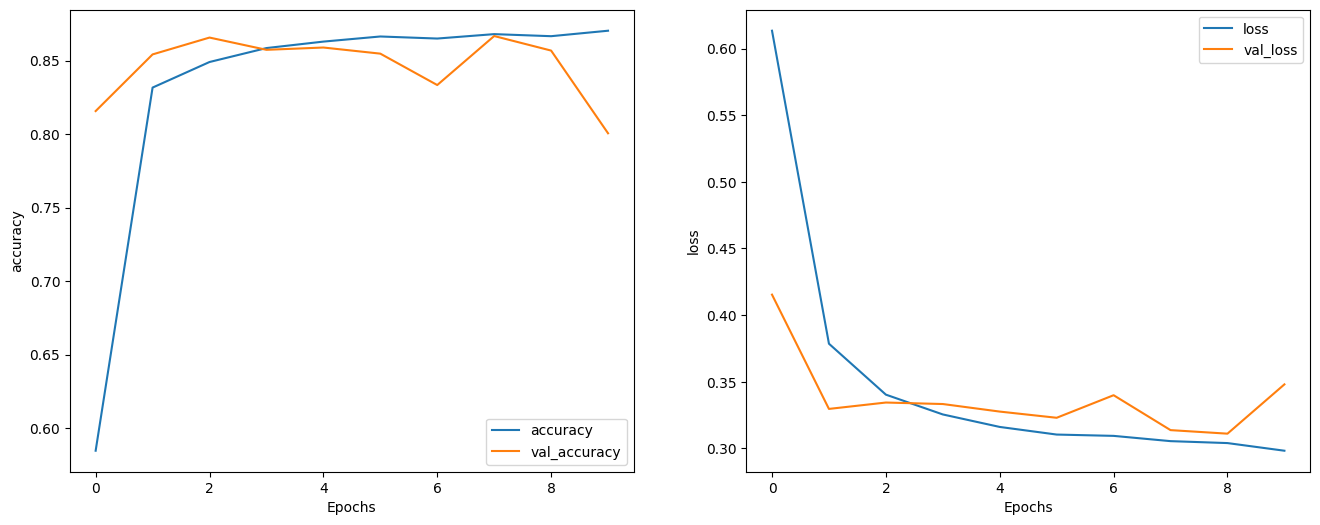

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Kode ini digunakan untuk membuat visualisasi dari riwayat pelatihan model menggunakan Matplotlib. Pada bagian pertama, ukuran figur diatur agar lebih lebar, yaitu 16x6 inci. Kemudian, dua subplot dibuat: yang pertama untuk menampilkan grafik akurasi model selama pelatihan dengan memanggil fungsi `plot_graphs` dan yang kedua untuk menampilkan grafik loss. Ini membantu dalam memantau performa model dan memahami bagaimana akurasi dan loss berubah seiring dengan waktu pelatihan.

# Praktikum 2 Generator Teks dengan RNN

# Setup

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Load Data

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


# Olah Teks
## Vectorize Teks

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

# Prediksi
## Membuat Trianing Set dan Target

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


## Membuat Batch Training

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# Buat Model

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

TypeError: Layer.__init__() takes 1 positional argument but 2 were given

# **Tugas**
Prosedur pelatihan pada praktikum 2 merupakan prosedur sederhana, yang tidak memberi Anda banyak kendali. Model ini menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan. Jadi, setelah Anda melihat cara menjalankan model secara manual, selanjutnya Anda akan mengimplementasikan custom loop pelatihan. Hal ini memberikan titik awal jika, misalnya, Anda ingin menerapkan pembelajaran kurikulum untuk membantu menstabilkan keluaran open-loop model. Bagian terpenting dari loop pelatihan khusus adalah fungsi langkah pelatihan.

Gunakan tf.GradientTape untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca eager execution guide.

Prosedurnya adalah :

1. Jalankan Model dan hitung loss dengan tf.GradientTape.

2. Hitung update dan terapkan pada model dengan optimizer

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return {'loss': loss}

Kode diatas menerapkan train_step method sesuai dengan  Keras' train_step conventions. Ini opsional, tetapi memungkinkan Anda mengubah perilaku langkah pelatihan dan tetap menggunakan keras Model.compile and Model.fit methods.

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?

**Jawab:**


Perbedaan utama antara tugas dan praktikum 2 terletak pada train yang digunakan. Praktikum 2 menggunakan train yang lebih umum dan sederhana dengan model.fit, sedangkan kode tuga menggunakan train yang khusus dan kompleks. Dalam pendekatan ini, ada penggunaan metode train_step dalam model turunan yang mengatur train pada tingkat batch. Ini melibatkan perhitungan loss, perhitungan gradien, peningkatan bobot model, dan pemanfaatan tf.metrics.Mean untuk menghitung rata-rata loss selama proses train. Dengan pendekatan ini, terdapat tingkat kontrol yang lebih besar dan fleksibilitas dalam mengatur proses train model.